In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import pandas as pd

PROJECT_ROOT = Path.cwd().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
from backtesting.global_loop import run_global_ranking_rebalance_walkforward
from object.class_file import BatchConfig, StrategyParams
from config.params import  START_DATE, END_DATE
from joblib import Parallel, delayed, cpu_count
import pandas as pd
import numpy as np
from utils.inline_scanner import InlineScannerConfig, build_scans_inline
import matplotlib.pyplot as plt
import seaborn as sns

### Pipeline

In [ ]:
PROJECT_ROOT = Path(".").resolve().parents[0]

UNIVERSES = ["sweden"]   # adapte
SCAN_FREQ = "B"                 # "B" = business days (recommandé) / "D" si tu veux daily pur

IS_START, IS_END   = "2023-12-31", "2024-12-31"
OOS_START, OOS_END = "2025-01-01", "2025-12-31"

In [5]:
inline_cfg = InlineScannerConfig(
    raw_data_path=PROJECT_ROOT / "data" / "raw" / "d1",
    asset_registry_path=PROJECT_ROOT / "data" / "asset_registry.csv",
    lookback_days=504,          # 2 ans de lookback (fixe)
    min_obs=100,
    liquidity_lookback=20,
    liquidity_min_moves=0.0,    # filtre "pas totalement flat"
)

In [6]:
scans_is = build_scans_inline(
    universes=UNIVERSES,
    start_date=IS_START,
    end_date=IS_END,
    freq=SCAN_FREQ,
    cfg=inline_cfg,
)

scans_oos = build_scans_inline(
    universes=UNIVERSES,
    start_date=OOS_START,
    end_date=OOS_END,
    freq=SCAN_FREQ,
    cfg=inline_cfg,
)

print("IS scans rows:", len(scans_is), "| dates:", scans_is["scan_date"].min(), "->", scans_is["scan_date"].max())
print("OOS scans rows:", len(scans_oos), "| dates:", scans_oos["scan_date"].min(), "->", scans_oos["scan_date"].max())



[SCAN] Universe=sweden | dates=262 | 2024-01-01 -> 2024-12-31
[SCAN] sweden |     1/262 (  0.4%) | last=2024-01-01 | frames=1 | 0.09 dates/s | ETA ~ 48.9 min
[SCAN] sweden |    10/262 (  3.8%) | last=2024-01-12 | frames=10 | 0.08 dates/s | ETA ~ 51.7 min
[SCAN] sweden |    20/262 (  7.6%) | last=2024-01-26 | frames=20 | 0.08 dates/s | ETA ~ 51.9 min
[SCAN] sweden |    30/262 ( 11.5%) | last=2024-02-09 | frames=30 | 0.08 dates/s | ETA ~ 47.9 min
[SCAN] sweden |    40/262 ( 15.3%) | last=2024-02-23 | frames=40 | 0.08 dates/s | ETA ~ 47.4 min
[SCAN] sweden |    50/262 ( 19.1%) | last=2024-03-08 | frames=50 | 0.08 dates/s | ETA ~ 43.4 min
[SCAN] sweden |    60/262 ( 22.9%) | last=2024-03-22 | frames=60 | 0.09 dates/s | ETA ~ 39.1 min
[SCAN] sweden |    70/262 ( 26.7%) | last=2024-04-05 | frames=70 | 0.09 dates/s | ETA ~ 35.6 min
[SCAN] sweden |    80/262 ( 30.5%) | last=2024-04-19 | frames=80 | 0.09 dates/s | ETA ~ 32.7 min
[SCAN] sweden |    90/262 ( 34.4%) | last=2024-05-03 | frames=90 

In [8]:
BASE_FEES = 0.0002
TOP_N = 20
MAX_POS = 5
REBAL_DAYS = 30

# Grilles heatmap
z_entries = [1.5, 1.75, 2.0, 2.25, 2.5]
z_windows = [40, 60, 80, 100]

In [10]:
cfg_is = BatchConfig(
    data_path=PROJECT_ROOT / "data" / "raw" / "d1",
    start_date=IS_START,
    end_date=IS_END,
)

cfg_oos = BatchConfig(
    data_path=PROJECT_ROOT / "data" / "raw" / "d1",
    start_date=OOS_START,
    end_date=OOS_END,
)

In [11]:
def run_for_params(z_window: int, z_entry: float, cfg: BatchConfig, scans: pd.DataFrame) -> float:
    params = StrategyParams(
        z_entry=z_entry,
        z_exit=0.25 * z_entry,
        z_stop=2.0 * z_entry,
        z_window=z_window,
        beta_mode="static",
        fees=BASE_FEES,
        top_n_candidates=TOP_N,
        max_positions=MAX_POS,
        rebalance_period=REBAL_DAYS,
    )

    res = run_global_ranking_rebalance_walkforward(
        cfg=cfg,
        params=params,
        universes=UNIVERSES,
        scans=scans,
    )

    if not res:
        return float("nan")

    return float(res["stats"]["Sharpe"])


In [12]:
n_jobs = max(cpu_count() - 1, 1)

results_is = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(run_for_params)(zw, ze, cfg_is, scans_is)
    for zw in z_windows
    for ze in z_entries
)

heatmap_is = pd.DataFrame(
    np.array(results_is).reshape(len(z_windows), len(z_entries)),
    index=z_windows,
    columns=z_entries,
)
heatmap_is.index.name = "z_window"
heatmap_is.columns.name = "z_entry"

heatmap_is

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  20 | elapsed:  1.3min remaining: 11.8min
[Parallel(n_jobs=11)]: Done   5 out of  20 | elapsed:  1.3min remaining:  3.9min
[Parallel(n_jobs=11)]: Done   8 out of  20 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=11)]: Done  11 out of  20 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=11)]: Done  14 out of  20 | elapsed:  2.4min remaining:  1.0min
[Parallel(n_jobs=11)]: Done  17 out of  20 | elapsed:  2.4min remaining:   25.6s
[Parallel(n_jobs=11)]: Done  20 out of  20 | elapsed:  2.4min finished


z_entry,1.50,1.75,2.00,2.25,2.50
z_window,,,,,
40,0.95,1.06,1.07,1.07,1.11
60,0.88,0.96,1.16,1.26,1.14
80,1.10,1.14,1.23,1.27,1.47
100,0.85,1.04,1.16,1.48,1.24


In [13]:
results_oos = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(run_for_params)(zw, ze, cfg_oos, scans_oos)
    for zw in z_windows
    for ze in z_entries
)

heatmap_oos = pd.DataFrame(
    np.array(results_oos).reshape(len(z_windows), len(z_entries)),
    index=z_windows,
    columns=z_entries,
)
heatmap_oos.index.name = "z_window"
heatmap_oos.columns.name = "z_entry"

heatmap_oos

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  20 | elapsed:  1.1min remaining: 10.2min
[Parallel(n_jobs=11)]: Done   5 out of  20 | elapsed:  1.2min remaining:  3.5min
[Parallel(n_jobs=11)]: Done   8 out of  20 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=11)]: Done  11 out of  20 | elapsed:  1.2min remaining:   58.5s
[Parallel(n_jobs=11)]: Done  14 out of  20 | elapsed:  2.2min remaining:   55.5s
[Parallel(n_jobs=11)]: Done  17 out of  20 | elapsed:  2.2min remaining:   22.9s
[Parallel(n_jobs=11)]: Done  20 out of  20 | elapsed:  2.2min finished


z_entry,1.50,1.75,2.00,2.25,2.50
z_window,,,,,
40,0.11,0.25,0.22,0.19,0.07
60,0.04,0.22,0.03,0.14,0.30
80,0.01,0.21,0.33,0.27,0.43
100,0.06,0.17,0.35,0.55,0.42


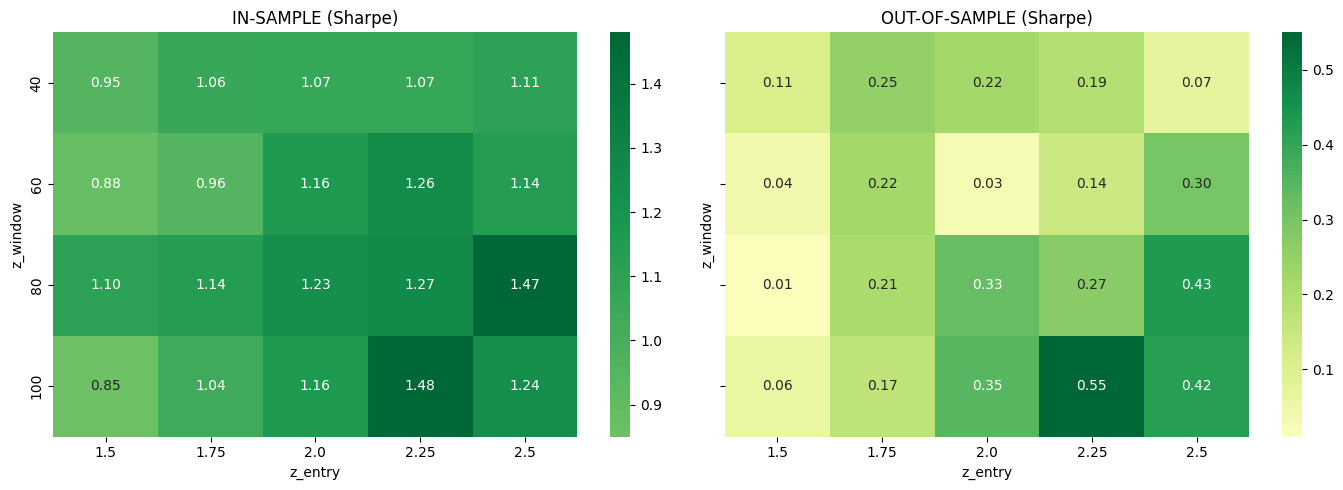

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.heatmap(heatmap_is, ax=axes[0], annot=True, fmt=".2f", cmap="RdYlGn", center=0.0)
axes[0].set_title("IN-SAMPLE (Sharpe)")

sns.heatmap(heatmap_oos, ax=axes[1], annot=True, fmt=".2f", cmap="RdYlGn", center=0.0)
axes[1].set_title("OUT-OF-SAMPLE (Sharpe)")

plt.tight_layout()
plt.show()

### Analyse simple

In [17]:
cfg = BatchConfig(
    data_path=PROJECT_ROOT / "data" / "raw" / "d1",
    start_date=IS_START,
    end_date=IS_END,
)

In [50]:
z_entry = 2.25
z_window = 100

params = StrategyParams(
        z_entry=z_entry,
        z_exit=0.25 * z_entry,
        z_stop=2.0 * z_entry,
        z_window=z_window,
        beta_mode="static",
        fees=BASE_FEES,
        top_n_candidates=TOP_N,
        max_positions=MAX_POS,
        rebalance_period=REBAL_DAYS,
    )

res = run_global_ranking_rebalance_walkforward(
    cfg=cfg,
    params=params,
    universes=UNIVERSES,
    scans=scans_is,
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2023-09-14 to 2024-01-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pair_id         139 non-null    object 
 1   asset_1         139 non-null    object 
 2   asset_2         139 non-null    object 
 3   y               139 non-null    float64
 4   x               139 non-null    float64
 5   beta            139 non-null    float64
 6   spread          139 non-null    float64
 7   z               40 non-null     float64
 8   eligible_today  139 non-null    bool   
dtypes: bool(1), float64(5), object(3)
memory usage: 9.9+ KB


In [42]:
scans_is

,eligibility,eligibility_score,n_valid_windows,beta_std,3m_beta,3m_corr,3m_adf_p,3m_eg_p,3m_half_life,3m_spread_std,...,12m_beta,12m_corr,12m_adf_p,12m_eg_p,12m_half_life,12m_spread_std,asset_1,asset_2,universe,scan_date
0,WATCH,1.180233,1,0.091208,0.640322,0.970015,0.155655,0.338381,4.124975,0.008540,...,0.419428,0.711972,0.004602,0.019793,7.164592,0.022776,ALFA_LAVAL_AB,ATLAS_COPCO_AB,sweden,2024-01-01
1,WATCH,0.541941,1,0.345636,0.807918,0.918085,0.004796,0.019110,1.884534,0.013928,...,0.055459,0.282516,0.124600,0.291757,12.938061,0.031113,ALFA_LAVAL_AB,ELECTROLUX_AB,sweden,2024-01-01
2,WATCH,1.274438,1,0.032843,0.689472,0.899701,0.197868,0.405076,5.632413,0.015338,...,0.747506,0.761880,0.004219,0.018353,6.969610,0.021008,ALFA_LAVAL_AB,INVESTOR_AB,sweden,2024-01-01
3,WATCH,1.284195,1,0.040013,0.711130,0.935994,0.228137,0.444312,5.037671,0.012369,...,0.658042,0.736950,0.001185,0.006011,6.725687,0.021924,ALFA_LAVAL_AB,SANDVIK_AB,sweden,2024-01-01
4,WATCH,0.721290,1,0.248078,0.735068,0.829029,0.002960,0.047415,4.329590,0.019649,...,0.133324,0.181036,0.116754,0.278565,13.686457,0.031898,ALFA_LAVAL_AB,SECURITAS_AB,sweden,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6255,WATCH,0.646092,1,0.265404,0.505232,0.835720,0.000120,0.000669,1.306738,0.008270,...,-0.070971,-0.091420,0.006418,0.026346,7.151933,0.025986,SKANDINAVISKA_ENSKILDA_BANKEN_AB,VOLVO_AB,sweden,2024-12-31
6256,WATCH,0.045429,1,0.681226,1.463877,0.648430,0.003852,0.016314,2.255395,0.022336,...,-0.199217,-0.416708,0.422923,0.667989,29.587283,0.064255,SKF_AB,TELEFONAKTIEBOLAGET_LM_ERICSSON,sweden,2024-12-31
6257,WATCH,-0.175742,1,0.761637,0.813991,0.825034,0.001408,0.006400,1.575702,0.011299,...,-0.957049,-0.737736,0.064766,0.177724,11.026247,0.040550,SVENSKA_CELLULOSA_AB,TELE2_AB,sweden,2024-12-31
6258,WATCH,0.026630,1,0.536728,0.660100,0.719579,0.045866,0.130395,2.791895,0.013885,...,-0.569705,-0.790301,0.062858,0.173730,11.195088,0.036804,SVENSKA_CELLULOSA_AB,TELIA_COMPANY_AB,sweden,2024-12-31


In [ ]:
scans_is = scans_is.drop_duplicates(
    subset=["asset_1", "asset_2", "scan_date"]
)

In [46]:
scans_is

,eligibility,eligibility_score,n_valid_windows,beta_std,3m_beta,3m_corr,3m_adf_p,3m_eg_p,3m_half_life,3m_spread_std,...,12m_beta,12m_corr,12m_adf_p,12m_eg_p,12m_half_life,12m_spread_std,asset_1,asset_2,universe,scan_date
0,WATCH,1.180233,1,0.091208,0.640322,0.970015,0.155655,0.338381,4.124975,0.008540,...,0.419428,0.711972,0.004602,0.019793,7.164592,0.022776,ALFA_LAVAL_AB,ATLAS_COPCO_AB,sweden,2024-01-01
1,WATCH,0.541941,1,0.345636,0.807918,0.918085,0.004796,0.019110,1.884534,0.013928,...,0.055459,0.282516,0.124600,0.291757,12.938061,0.031113,ALFA_LAVAL_AB,ELECTROLUX_AB,sweden,2024-01-01
2,WATCH,1.274438,1,0.032843,0.689472,0.899701,0.197868,0.405076,5.632413,0.015338,...,0.747506,0.761880,0.004219,0.018353,6.969610,0.021008,ALFA_LAVAL_AB,INVESTOR_AB,sweden,2024-01-01
3,WATCH,1.284195,1,0.040013,0.711130,0.935994,0.228137,0.444312,5.037671,0.012369,...,0.658042,0.736950,0.001185,0.006011,6.725687,0.021924,ALFA_LAVAL_AB,SANDVIK_AB,sweden,2024-01-01
4,WATCH,0.721290,1,0.248078,0.735068,0.829029,0.002960,0.047415,4.329590,0.019649,...,0.133324,0.181036,0.116754,0.278565,13.686457,0.031898,ALFA_LAVAL_AB,SECURITAS_AB,sweden,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6255,WATCH,0.646092,1,0.265404,0.505232,0.835720,0.000120,0.000669,1.306738,0.008270,...,-0.070971,-0.091420,0.006418,0.026346,7.151933,0.025986,SKANDINAVISKA_ENSKILDA_BANKEN_AB,VOLVO_AB,sweden,2024-12-31
6256,WATCH,0.045429,1,0.681226,1.463877,0.648430,0.003852,0.016314,2.255395,0.022336,...,-0.199217,-0.416708,0.422923,0.667989,29.587283,0.064255,SKF_AB,TELEFONAKTIEBOLAGET_LM_ERICSSON,sweden,2024-12-31
6257,WATCH,-0.175742,1,0.761637,0.813991,0.825034,0.001408,0.006400,1.575702,0.011299,...,-0.957049,-0.737736,0.064766,0.177724,11.026247,0.040550,SVENSKA_CELLULOSA_AB,TELE2_AB,sweden,2024-12-31
6258,WATCH,0.026630,1,0.536728,0.660100,0.719579,0.045866,0.130395,2.791895,0.013885,...,-0.569705,-0.790301,0.062858,0.173730,11.195088,0.036804,SVENSKA_CELLULOSA_AB,TELIA_COMPANY_AB,sweden,2024-12-31


In [19]:
res["stats"]

{'Final Equity': 186.28,
 'CAGR': 0.202,
 'Sharpe': np.float64(1.48),
 'Max Drawdown': np.float64(-0.428),
 'Nb Trades': 855}

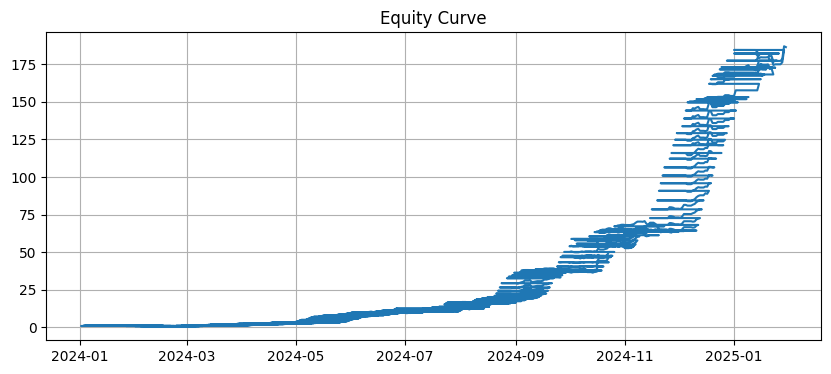

In [20]:
eq = res["equity"]

plt.figure(figsize=(10, 4))
plt.plot(eq["datetime"], eq["equity"])
plt.title("Equity Curve")
plt.grid(True)
plt.show()

In [21]:
res["trades"].groupby('reason').agg({'pair_id': 'count', 'pnl_spread': ['sum', 'median', 'std']}).round(4)

pair_id pnl_spread                
         count        sum  median     std
reason                                   
SL         109    -1.7010 -0.0146  0.0107
TIME       388    -1.8624 -0.0029  0.0239
TP         347    14.7013  0.0397  0.0160

In [30]:
import datetime
res["trades"]

,pair_id,asset_1,asset_2,side,beta,entry_datetime,entry_z,entry_spread,exit_datetime,exit_z,exit_spread,pnl_spread,reason,duration_days
0,ATLAS_COPCO_AB_SANDVIK_AB,ATLAS_COPCO_AB,SANDVIK_AB,SHORT_SPREAD,1.248424,2024-01-22,2.500950,-0.571531,2024-01-25,-3.910531,-0.662647,0.091117,TP,3.0
1,ATLAS_COPCO_AB_SANDVIK_AB,ATLAS_COPCO_AB,SANDVIK_AB,LONG_SPREAD,1.248424,2024-01-25,-3.910531,-0.662647,2024-01-31,-2.041274,-0.643035,0.019612,TIME,6.0
2,NORDEA_BANK_AB_SKANDINAVISKA_ENSKILDA_BANKEN_AB,NORDEA_BANK_AB,SKANDINAVISKA_ENSKILDA_BANKEN_AB,SHORT_SPREAD,0.494936,2024-01-04,3.682253,0.105488,2024-01-12,0.359607,0.080088,0.025399,TP,8.0
3,ALFA_LAVAL_AB_SANDVIK_AB,ALFA_LAVAL_AB,SANDVIK_AB,LONG_SPREAD,0.762365,2024-01-12,-2.618619,0.612179,2024-02-01,-1.089931,0.614674,0.002495,TIME,20.0
4,ATLAS_COPCO_AB_SANDVIK_AB,ATLAS_COPCO_AB,SANDVIK_AB,SHORT_SPREAD,1.247536,2024-01-22,2.504807,-0.571137,2024-01-25,-3.910218,-0.662213,0.091076,TP,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,SKANDINAVISKA_ENSKILDA_BANKEN_AB_TELIA_COMPANY_AB,SKANDINAVISKA_ENSKILDA_BANKEN_AB,TELIA_COMPANY_AB,SHORT_SPREAD,0.135670,2025-01-15,3.000299,1.061371,2025-01-29,0.662109,1.038128,0.023243,TIME,14.0
851,SKANDINAVISKA_ENSKILDA_BANKEN_AB_SKF_AB,SKANDINAVISKA_ENSKILDA_BANKEN_AB,SKF_AB,SHORT_SPREAD,0.112701,2025-01-15,2.886035,1.017269,2025-01-29,0.613414,0.996585,0.020684,TIME,14.0
852,SKANDINAVISKA_ENSKILDA_BANKEN_AB_TELE2_AB,SKANDINAVISKA_ENSKILDA_BANKEN_AB,TELE2_AB,SHORT_SPREAD,0.324461,2025-01-13,2.615479,1.101084,2025-01-29,-0.097898,1.065798,0.035286,TP,16.0
853,SKANDINAVISKA_ENSKILDA_BANKEN_AB_TELIA_COMPANY_AB,SKANDINAVISKA_ENSKILDA_BANKEN_AB,TELIA_COMPANY_AB,SHORT_SPREAD,0.135670,2025-01-15,3.000299,1.061371,2025-01-30,0.819055,1.042694,0.018677,TIME,15.0


In [41]:
res["trades"].loc[res["trades"]["entry_datetime"] == datetime.datetime(2024, 1, 4, 0, 0, 0), :].to_clipboard()

In [40]:
res["trades"].loc[res["trades"]["entry_datetime"] == datetime.datetime(2024, 1, 12, 0, 0, 0), :]

,pair_id,asset_1,asset_2,side,beta,entry_datetime,entry_z,entry_spread,exit_datetime,exit_z,exit_spread,pnl_spread,reason,duration_days
3,ALFA_LAVAL_AB_SANDVIK_AB,ALFA_LAVAL_AB,SANDVIK_AB,LONG_SPREAD,0.762365,2024-01-12,-2.618619,0.612179,2024-02-01,-1.089931,0.614674,0.002495,TIME,20.0
